<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Consumption needs of buildings - Project 4</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h2 style="width: 100%; text-align: center; float: left;" align="center">| Analysis notebook |</h2>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; font-size:26px; float: left;" align="center">Data Scientist course - OpenClassrooms</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
import ast
import itertools
import math
from math import prod
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot


%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h4>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("display.max_colwidth", None) # show full width of showing cols
        pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell 
        
        if type_analysis is None or type_analysis != "complete":
            print("\n- Type object and records by columns      (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif type_analysis == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns      (",memory_usage,")")
            print("--------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        pd.reset_option("display.float_format") # reset show full content in cell 
        
        # deleting dataframe to free memory
        if type_analysis == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

            
def normality_test(df):
    """
    Method used for make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h4>
</div>

In [3]:
data_2015 = pd.read_csv(r"datasets\2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv(r"datasets\2016-building-energy-benchmarking.csv")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.2. Initial analysis</h4>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [4]:
df_analysis(data_2015, "data_2015")


Analysis of data_2015 dataset
--------------------------------------------------------------------
- Dataset shape:                  3340 rows and 47 columns
- Total of NaN values:            26512
- Percentage of NaN:              16.89 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3340,0,0.00000
9,YearBuilt,int64,3340,0,0.00000
40,ComplianceStatus,object,3340,0,0.00000
1,DataYear,int64,3340,0,0.00000
14,PropertyGFABuilding(s),int64,3340,0,0.00000
13,PropertyGFAParking,int64,3340,0,0.00000
12,PropertyGFATotal,int64,3340,0,0.00000
10,NumberofBuildings,int64,3340,0,0.00000
46,Zip Codes,int64,3340,0,0.00000
8,Neighborhood,object,3340,0,0.00000


In [5]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols

In [6]:
data_2015.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081


In [7]:
df_analysis(data_2016, "data_2016")


Analysis of data_2016 dataset
--------------------------------------------------------------------
- Dataset shape:                  3376 rows and 46 columns
- Total of NaN values:            19952
- Percentage of NaN:              12.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Comments']
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3376,0,0.00000
11,Neighborhood,object,3376,0,0.00000
1,DataYear,int64,3376,0,0.00000
40,DefaultData,bool,3376,0,0.00000
42,ComplianceStatus,object,3376,0,0.00000
19,PropertyGFABuilding(s),int64,3376,0,0.00000
18,PropertyGFAParking,int64,3376,0,0.00000
17,PropertyGFATotal,int64,3376,0,0.00000
14,YearBuilt,int64,3376,0,0.00000
13,Longitude,float64,3376,0,0.00000


In [8]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols

In [9]:
data_2016.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Cleaning</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.1. Formatting columns</h4>
</div>

<div class="alert alert-block alert-info">
    Splitting the featured <b>Location</b> in <b>data_2015</b>
</div>

In [10]:
df_temp = data_2015["Location"].apply(lambda x: ast.literal_eval(x))
data_2015[["Latitude", "Longitude", "HumanAddress"]] = df_temp.apply(pd.Series)

In [11]:
data_2015.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude,HumanAddress
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61310583,-122.33335756,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}"


<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    In this way, we can <b>identify similar features</b> between datasets
    
     <ul style="list-style-type: square;">
        <li><b>GHGEmissions(MetricTonsCO2e)</b> in <b>data_2015</b> is the same feature as <b>TotalGHGEmissions</b> in <b>data_2016</b></li>
        <li><b>GHGEmissionsIntensity(kgCO2e/ft2)</b> in <b>data_2015</b> is the same feature as <b>GHGEmissionsIntensity</b> in <b>data_2016</b></li>
    </ul>
    
     On the other hands, we have the following
    <ul style="list-style-type: square;">
        <li><b>Zip Codes</b> in <b>data_2015</b> is the same feature as <b>ZipCode</b> in <b>data_2016</b></li>
    </ul>
</div>

In [12]:
data_2015["ZipCode"] = data_2015["Zip Codes"]
data_2016["GHGEmissionsIntensity(kgCO2e/ft2)"] = data_2016["GHGEmissionsIntensity"]
data_2016["GHGEmissions(MetricTonsCO2e)"] = data_2016["TotalGHGEmissions"]

data_2015.drop(labels=["Zip Codes"], axis=1, inplace=True)
data_2016.drop(labels=["GHGEmissionsIntensity", "TotalGHGEmissions"], axis=1, inplace=True)

<div class="alert alert-block alert-info">
<b>Comparing</b> the match between columns <b>before</b> making the <b>concatenation</b>
</div>

In [13]:
LIST_COL, LIST_ORIGIN = ([] for i in range(2))

for col in data_2015.columns:
    if col not in list(data_2016.columns):
        LIST_COL.append(col)
        LIST_ORIGIN.append("data_2015")
        
for col in data_2016.columns:
    if col not in list(data_2015.columns):
        LIST_COL.append(col)
        LIST_ORIGIN.append("data_2016")

df_columns_not_matches = pd.DataFrame({
    "column": LIST_COL,
    "origin": LIST_ORIGIN
})

In [14]:
df_columns_not_matches.sort_values("column")

,column,origin
3,2010 Census Tracts,data_2015
8,Address,data_2016
9,City,data_2016
5,City Council Districts,data_2015
2,Comment,data_2015
11,Comments,data_2016
7,HumanAddress,data_2015
0,Location,data_2015
1,OtherFuelUse(kBtu),data_2015
6,SPD Beats,data_2015


<div class="alert alert-block alert-info">
<b>Eliminate</b> the columns that do not matched between the two datasetsm because they are not interesting for the mission
</div>

In [15]:
data_2015.drop(labels=list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2015", "column"]), axis=1, inplace=True)
data_2016.drop(labels=list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"]), axis=1, inplace=True)

<div class="alert alert-block alert-info">
<b>Comparing</b> the types of each par of column <b>before</b> making the <b>concatenation</b>
    
</div>

In [16]:
data_2015 = data_2015.reindex(sorted(data_2015.columns), axis=1)
data_2016 = data_2016.reindex(sorted(data_2016.columns), axis=1)

In [17]:
def types_different(data_2015, data_2016):
    
    LIST_COL_DIFFERENT, LIST_DTYPE_2015, LIST_DTYPE_2016 = [[] for i in range(3)]
    
    for col_2015, col_2016 in zip(data_2015.columns, data_2016.columns):
        if data_2015[col_2015].dtype != data_2016[col_2016].dtype:
            LIST_COL_DIFFERENT.append(col_2015)
            LIST_DTYPE_2015.append(str(data_2015[col_2015].dtype))
            LIST_DTYPE_2016.append(str(data_2016[col_2016].dtype))
            
    df_types_different = pd.DataFrame({
                            "column": LIST_COL_DIFFERENT,
                            "2015": LIST_DTYPE_2015,
                            "2016": LIST_DTYPE_2016
                        })
    
    return df_types_different

In [18]:
df_types_different = types_different(data_2015, data_2016)
df_types_different

,column,2015,2016
0,DefaultData,object,bool
1,Latitude,object,float64
2,Longitude,object,float64
3,NumberofBuildings,int64,float64
4,NumberofFloors,float64,int64
5,ZipCode,int64,float64


<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b>
</div>

In [19]:
data_2015["DefaultData"] = data_2015["DefaultData"].astype("bool")
data_2015["Latitude"] = data_2015["Latitude"].astype("float64")
data_2015["Longitude"] = data_2015["Longitude"].astype("float64")

data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].fillna(0)
data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].astype("int64")

data_2015["NumberofFloors"] = data_2015["NumberofFloors"].fillna(0)
data_2015["NumberofFloors"] = data_2015["NumberofFloors"].astype("int64")

data_2016["ZipCode"] = data_2016["ZipCode"].fillna(0)
data_2016["ZipCode"] = data_2016["ZipCode"].astype("int64")

df_types_different = types_different(data_2015, data_2016)
df_types_different

,column,2015,2016


<div class="alert alert-block alert-info">
    <b>Deleting</b> the columns over <b>80%</b> of <b>missing-values</b>
</div>

In [20]:
data_2015 = data_2015.loc[:, data_2015.isnull().mean() < .8]
data_2016 = data_2016.loc[:, data_2016.isnull().mean() < .8]

<div class="alert alert-block alert-info">
    <b>Concatenating</b> the datasets
</div>

In [21]:
data = pd.concat([data_2015, data_2016], ignore_index=True).reset_index(drop=True)

In [22]:
df_analysis(data, "data")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  6716 rows and 38 columns
- Total of NaN values:            9264
- Percentage of NaN:              3.63 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.9+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,BuildingType,object,6716,0,0.00000
14,Longitude,float64,6716,0,0.00000
36,YearBuilt,int64,6716,0,0.00000
25,PropertyName,object,6716,0,0.00000
24,PropertyGFATotal,int64,6716,0,0.00000
23,PropertyGFAParking,int64,6716,0,0.00000
22,PropertyGFABuilding(s),int64,6716,0,0.00000
21,PrimaryPropertyType,object,6716,0,0.00000
20,OSEBuildingID,int64,6716,0,0.00000
1,ComplianceStatus,object,6716,0,0.00000


In [23]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols
data.head(5)

,BuildingType,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseType,LargestPropertyUseTypeGFA,Latitude,ListOfAllPropertyUseTypes,Longitude,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,YearBuilt,ZipCode
0,NonResidential,Compliant,7,2015,True,65.0,3686160.0,1080307.0,249.43,2.64,Hotel,88434.0,47.612190,Hotel,-122.337997,1272388.0,12724.0,DOWNTOWN,1,12,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,659000030,1927,18081
1,NonResidential,Compliant,7,2015,True,51.0,3905411.0,1144563.0,263.51,2.38,Hotel,83880.0,47.613106,"Hotel, Parking, Restaurant",-122.333358,4448985.0,44490.0,DOWNTOWN,1,11,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,659000220,1996,18081
2,NonResidential,Compliant,7,2015,True,18.0,49762435.0,14583930.0,2061.48,1.92,Hotel,757243.0,47.613349,"Hotel, Parking, Swimming Pool",-122.337699,3709900.0,37099.0,DOWNTOWN,1,41,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,659000475,1969,18081
3,NonResidential,Compliant,7,2015,True,1.0,2769023.0,811521.0,1936.34,31.38,Hotel,61320.0,47.614216,Hotel,-122.336609,2001894.0,20019.0,DOWNTOWN,1,10,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,460.4,462.5,28229320.0,28363444.0,636.3,643.2,23458518.0,659000640,1926,18081
4,NonResidential,Compliant,7,2015,True,67.0,6066245.0,1777841.0,507.70,4.02,Hotel,123445.0,47.613754,"Hotel, Parking, Swimming Pool",-122.340924,8763105.0,87631.0,DOWNTOWN,1,18,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,659000970,1980,19576


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2. Identifying and formatting categorical columns</h4>
</div>

In [24]:
data[list(set(data.columns) - set(data._get_numeric_data()))].head(10)

,ListOfAllPropertyUseTypes,ComplianceStatus,LargestPropertyUseType,PrimaryPropertyType,SecondLargestPropertyUseType,TaxParcelIdentificationNumber,PropertyName,Neighborhood,BuildingType
0,Hotel,Compliant,Hotel,Hotel,NaN,659000030,MAYFLOWER PARK HOTEL,DOWNTOWN,NonResidential
1,"Hotel, Parking, Restaurant",Compliant,Hotel,Hotel,Parking,659000220,PARAMOUNT HOTEL,DOWNTOWN,NonResidential
2,"Hotel, Parking, Swimming Pool",Compliant,Hotel,Hotel,Parking,659000475,WESTIN HOTEL,DOWNTOWN,NonResidential
3,Hotel,Compliant,Hotel,Hotel,NaN,659000640,HOTEL MAX,DOWNTOWN,NonResidential
4,"Hotel, Parking, Swimming Pool",Compliant,Hotel,Hotel,Parking,659000970,WARWICK SEATTLE HOTEL,DOWNTOWN,NonResidential
5,Police Station,Compliant,Police Station,Other,NaN,660000560,WEST PRECINCT (SEATTLE POLICE),DOWNTOWN,Nonresidential COS
6,Hotel,Compliant,Hotel,Hotel,NaN,660000825,CAMLIN WORLDMARK HOTEL,DOWNTOWN,NonResidential
7,Other - Entertainment/Public Assembly,Compliant,Other - Entertainment/Public Assembly,Other,NaN,660000955,PARAMOUNT THEATER,DOWNTOWN,NonResidential
8,Hotel,Compliant,Hotel,Hotel,NaN,939000080,COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE,DOWNTOWN,NonResidential
9,Multifamily Housing,Compliant,Multifamily Housing,Mid-Rise Multifamily,NaN,939000105,LYON BUILDING,DOWNTOWN,Multifamily MR (5-9)


In [25]:
for col in list(set(data.columns) - set(data._get_numeric_data())):
    print(col)
    display(data[col].unique())

ListOfAllPropertyUseTypes


array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       nan, 'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse, Office',
       'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       'Non-Refrigerated Warehouse, Other, Retail Store',
       'Office, Retail Store',
       'Office, Other - Entertainment/Public Assembly, Restaurant',
   

ComplianceStatus


array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

LargestPropertyUseType


array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

PrimaryPropertyType


array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

SecondLargestPropertyUseType


array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Laboratory', 'Movie Theater', 'Supermarket/Grocery Store',
       'Medical Office', 'Other - Recreation',
       'Convenience Store without Gas Station',
       'Fitness Center/Health Club/Gym', 'Performing Arts',
       'College/University', 'Other - Restaurant/Bar', 'Adult Education',
       'Multifamily Housing', 'Bar/Nightclub', 'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Bank Branch', 'Food Service',
       'Worship Facility', 'Senior Care Community',
       'Refrigerated Warehouse', 'Hotel', 'Food Sales',
       'Other/Specialty H

TaxParcelIdentificationNumber


array(['659000030', '659000220', '659000475', ..., '1624049080',
       '7883603155', '7857002030'], dtype=object)

PropertyName


array(['MAYFLOWER PARK HOTEL', 'PARAMOUNT HOTEL', 'WESTIN HOTEL', ...,
       'Queen Anne Pool', 'South Park Community Center',
       'Van Asselt Community Center'], dtype=object)

Neighborhood


array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Central',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

BuildingType


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

<div class="alert alert-block alert-info">
    <b>Cleaning</b> data in the features
</div>

In [26]:
data["ComplianceStatus"].replace("Non-Compliant", "Not Compliant", inplace=True)
data["ComplianceStatus"].replace("Missing Data", np.nan, inplace=True)
data["ComplianceStatus"].replace("Error - Correct Default Data", np.nan, inplace=True)
data["Neighborhood"].replace("Ballard", "BALLARD", inplace=True)
data["Neighborhood"].replace("Central", "CENTRAL", inplace=True)
data["Neighborhood"].replace("North", "NORTH", inplace=True)
data["Neighborhood"].replace("Delridge", "DELRIDGE", inplace=True)
data["Neighborhood"].replace("DELRIDGE NEIGHBORHOODS", "DELRIDGE", inplace=True)
data["Neighborhood"].replace("Northwest", "NORTHWEST", inplace=True)


data["PrimaryPropertyType"].replace("Restaurant\n", "Restaurant", inplace=True)
data["PrimaryPropertyType"].replace("Self-Storage Facility\n", "Self-Storage Facility", inplace=True)
data["PrimaryPropertyType"].replace("Distribution Center\n", "Distribution Center", inplace=True)
data["PrimaryPropertyType"].replace("Small- and Mid-Sized Office", "Small and Mid-Sized Office", inplace=True)
data["PrimaryPropertyType"].replace("Supermarket / Grocery Store", "Supermarket/Grocery Store", inplace=True)

<div class="alert alert-block alert-info">
    <b>Changing</b> the type of data <b>Neighborhood</b>
</div>

In [27]:
for col in list(set(data.columns) - set(data._get_numeric_data())):
    data[col] = data[col].astype("category")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3. Filtering information</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the mision, we are going to <b>filter</b> the <b>types of building</b> considering only "non residential" buildings
</div>

In [28]:
data["BuildingType"].unique()

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)', 'Nonresidential WA']
Categories (8, object): ['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)', 'Nonresidential WA']

In [29]:
data = pd.DataFrame(data[~data["BuildingType"].str.contains("family", case=False, na=False).any(level=0)])

In [30]:
data["BuildingType"].unique()

['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']
Categories (5, object): ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

<div class="alert alert-block alert-info">
    Based on the mision, we are going to <b>filter</b> the <b>PrimaryPropertyType</b> considering only "non residential" buildings
</div>

In [31]:
data = data[~data["PrimaryPropertyType"].isin(["Residence Hall", "Residence Hall/Dormitory", "Low-Rise Multifamily"])]

<div class="alert alert-block alert-info">
    Groupinig by <b>PrimaryPropertyType</b> 
</div>

In [32]:
PROPERTY_TYPE = data["PrimaryPropertyType"].unique().to_list()
PROPERTY_TYPE

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Non-Refrigerated Warehouse',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'University',
 'Warehouse',
 'Office']

In [33]:
RENAME_PROPERTY_TYPE = [
    "Hotel", "Other", "Store/Restaurant", "Education", "Education", "Office", "Warehouse", 
    "Warehouse", "Office", "Retail Store", "Health", "Office", "Health", "Warehouse", 
    "Education", "Other",  "Retail Store", "Other", "Refrigerated Warehouse", "Store/Restaurant", "Education", 
    "Warehouse", "Office"  
]

In [34]:
df_property_type_rename = pd.DataFrame({
    "PrimaryPropertyType" : PROPERTY_TYPE,
    "renamed_PrimaryPropertyType" : RENAME_PROPERTY_TYPE
})
df_property_type_rename

,PrimaryPropertyType,renamed_PrimaryPropertyType
0,Hotel,Hotel
1,Other,Other
2,Mixed Use Property,Store/Restaurant
3,K-12 School,Education
4,College/University,Education
5,Small and Mid-Sized Office,Office
6,Self-Storage Facility,Warehouse
7,Distribution Center,Warehouse
8,Large Office,Office
9,Retail Store,Retail Store


In [35]:
data = data.merge(right=df_property_type_rename[["PrimaryPropertyType", "renamed_PrimaryPropertyType"]], on="PrimaryPropertyType", how="left")

In [36]:
df_analysis(data, "data")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 39 columns
- Total of NaN values:            4775
- Percentage of NaN:              3.74 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,BuildingType,category,3277,0,0.00000
14,Longitude,float64,3277,0,0.00000
37,ZipCode,int64,3277,0,0.00000
36,YearBuilt,int64,3277,0,0.00000
25,PropertyName,category,3277,0,0.00000
24,PropertyGFATotal,int64,3277,0,0.00000
23,PropertyGFAParking,int64,3277,0,0.00000
22,PropertyGFABuilding(s),int64,3277,0,0.00000
21,PrimaryPropertyType,object,3277,0,0.00000
20,OSEBuildingID,int64,3277,0,0.00000


<div class="alert alert-block alert-success">
    At this point, we get a <b>dataset shape 3277 rows and 39</b>
</div>

In [37]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols
data.head(10)

,BuildingType,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseType,LargestPropertyUseTypeGFA,Latitude,ListOfAllPropertyUseTypes,Longitude,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,YearBuilt,ZipCode,renamed_PrimaryPropertyType
0,NonResidential,Compliant,7,2015,True,65.0,3686160.0,1080307.0,249.43,2.64,Hotel,88434.0,47.612190,Hotel,-122.337997,1272388.0,12724.0,DOWNTOWN,1,12,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,659000030,1927,18081,Hotel
1,NonResidential,Compliant,7,2015,True,51.0,3905411.0,1144563.0,263.51,2.38,Hotel,83880.0,47.613106,"Hotel, Parking, Restaurant",-122.333358,4448985.0,44490.0,DOWNTOWN,1,11,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,659000220,1996,18081,Hotel
2,NonResidential,Compliant,7,2015,True,18.0,49762435.0,14583930.0,2061.48,1.92,Hotel,757243.0,47.613349,"Hotel, Parking, Swimming Pool",-122.337699,3709900.0,37099.0,DOWNTOWN,1,41,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,659000475,1969,18081,Hotel
3,NonResidential,Compliant,7,2015,True,1.0,2769023.0,811521.0,1936.34,31.38,Hotel,61320.0,47.614216,Hotel,-122.336609,2001894.0,20019.0,DOWNTOWN,1,10,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,460.4,462.5,28229320.0,28363444.0,636.3,643.2,23458518.0,659000640,1926,18081,Hotel
4,NonResidential,Compliant,7,2015,True,67.0,6066245.0,1777841.0,507.70,4.02,Hotel,123445.0,47.613754,"Hotel, Parking, Swimming Pool",-122.340924,8763105.0,87631.0,DOWNTOWN,1,18,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,659000970,1980,19576,Hotel
5,Nonresidential COS,Compliant,7,2015,True,NaN,7271004.0,2130921.0,304.62,2.81,Police Station,88830.0,47.616439,Police Station,-122.336764,4781283.0,47813.0,DOWNTOWN,1,2,9,Other,60090,37198,97288,WEST PRECINCT (SEATTLE POLICE),NaN,NaN,135.7,146.9,12051984.0,13045258.0,313.5,321.6,0.0,660000560,1999,19576,Other
6,NonResidential,Compliant,7,2015,True,25.0,2679698.0,785342.0,208.46,2.37,Hotel,81352.0,47.614114,Hotel,-122.332741,3573255.0,35733.0,DOWNTOWN,1,11,10,Hotel,83008,0,83008,CAMLIN WORLDMARK HOTEL,NaN,NaN,76.9,79.6,6252842.0,6477493.0,149.5,158.2,0.0,660000825,1926,18081,Hotel
7,NonResidential,Compliant,7,2015,True,NaN,4108004.0,1203937.0,199.99,1.77,Other - Entertainment/Public Assembly,102761.0,47.612902,Other - Entertainment/Public Assembly,-122.331309,315079.0,3151.0,DOWNTOWN,1,8,11,Other,102761,0,102761,PARAMOUNT THEATER,NaN,NaN,62.5,71.8,6426022.0,7380086.0,152.2,160.4,2003108.0,660000955,1926,18081,Other
8,NonResidential,Compliant,7,2015,True,46.0,7355649.0,2155728.0,331.61,1.83,Hotel,163984.0,47.602589,Hotel,-122.332553,5278400.0,52784.0,DOWNTOWN,1,15,12,Hotel,163984,0,163984,COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE,NaN,NaN,77.0,82.9,12633744.0,13589025.0,174.6,186.8,0.0,939000080,1904,18379,Hotel
9,NonResidential,Compliant,7,2015,True,48.0,6337531.0,1857347.0,576.63,3.59,NaN,NaN,47.607121,NaN,-122.334319,4759044.0,47590.0,DOWNTOWN,1,11,15,Hotel,133884,19279,153163,HOTEL MONACO,NaN,NaN,101.1,107.2,14719853.0,15615929.0,200.8,205.2,3623542.0,942000145,1969,18081,Hotel


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4. Selecting the features</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
</div>

In [38]:
LIST_FEATURES = [
    "OSEBuildingID", "DataYear", "PrimaryPropertyType", "renamed_PrimaryPropertyType", "YearBuilt", 
    "PropertyGFATotal", "NumberofFloors", "NumberofBuildings", "ZipCode", "Neighborhood", 
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", 
    "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", 
    "SteamUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)", "ENERGYSTARScore"
]

<div class="alert alert-block alert-danger">
Flag position
</div>

 - GHGEmissions(MetricTonsCO2e)
 - SiteEnergyUse(kBtu)

In [39]:
df_to_work = pd.DataFrame(data[LIST_FEATURES])

In [40]:
df_analysis(df_to_work, "df_to_work", type_analysis="complete")


Analysis of df_to_work dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            1201
- Percentage of NaN:              1.67 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 696.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
6,NumberofFloors,int64,3277,45,0,0.00000,4.11993,0.00000,1.00000,2.00000,4.00000,99.00000,6.59411
7,NumberofBuildings,int64,3277,18,0,0.00000,1.11840,0.00000,1.00000,1.00000,1.00000,111.00000,2.23307
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007


<div class="alert alert-block alert-info">
    At this point, we get some negatives values. So, let's consider the following <b>hypothesis</b>. <br> 
    In <b>this case</b> it is not possible to have <b>negative values</b>, due to that, we are going to <b>format</b> all dataframe with <b>absolute values</b>.
</div>

In [41]:
for col in set(df_to_work._get_numeric_data()):
    df_to_work[col] = df_to_work[col].abs()

In [42]:
df_analysis(df_to_work, "df_to_work", type_analysis="complete")


Analysis of df_to_work dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            1201
- Percentage of NaN:              1.67 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 696.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
6,NumberofFloors,int64,3277,45,0,0.00000,4.11993,0.00000,1.00000,2.00000,4.00000,99.00000,6.59411
7,NumberofBuildings,int64,3277,18,0,0.00000,1.11840,0.00000,1.00000,1.00000,1.00000,111.00000,2.23307
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007


<div class="alert alert-block alert-info">
    We can see some properties that have <b>(NumberofBuildings = 0)</b> and <b>(NumberofFloors = 0)</b>. We are going to <b>replace</b> these values by <b>NaN</b>
</div>

In [43]:
df_to_work.loc[df_to_work["NumberofBuildings"] == 0, "NumberofBuildings"] = np.NaN
df_to_work.loc[df_to_work["NumberofFloors"] == 0, "NumberofFloors"] = np.NaN

<div class="alert alert-block alert-info">
    Alse, we've noticed an <b>outliers</b> in <b>NumberofBuildings</b> that we are going to treat alone
</div>

In [44]:
df_to_work.loc[df_to_work["NumberofBuildings"] == 111, "NumberofBuildings"] = np.NaN

In [45]:
df_analysis(df_to_work, "df_to_work", type_analysis="complete")


Analysis of df_to_work dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            1280
- Percentage of NaN:              1.78 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 696.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
14,SiteEnergyUse(kBtu),float64,3268,3250,9,0.27000,8132269.46680,0.00000,1221320.28125,2515115.00000,6992292.12500,873923712.00000,25404202.19913
20,GHGEmissionsIntensity(kgCO2e/ft2),float64,3268,579,9,0.27000,1.47948,0.00000,0.27000,0.77000,1.73250,34.09000,2.22483


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Treating Outliers</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.1. Treating Outliers with Z Score</h4>
</div>

<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>Z Score</b>
</div>

In [46]:
df_without_outliers = pd.DataFrame()

# List de features to excluded because they seem ok
LIST_FEATURES_TO_BE_EXCLUDED = ["OSEBuildingID", "YearBuilt", "DataYear", "ZipCode", "NumberofFloors", "NumberofBuildings"]

for property_type in df_to_work["PrimaryPropertyType"].unique():
    
    # for each property type, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_to_work[df_to_work["PrimaryPropertyType"] == property_type].copy()
    
    for col in set(df_temp_outliers._get_numeric_data()):
        
        if col not in LIST_FEATURES_TO_BE_EXCLUDED:
            # Defining the Z Score
            df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
            df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan

            del df_temp_outliers[col + "_zscore"]
        
    df_without_outliers = pd.concat([df_without_outliers, df_temp_outliers])

In [47]:
df_analysis(df_without_outliers, "df_without_outliers", type_analysis="complete")


Analysis of df_without_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            2034
- Percentage of NaN:              2.82 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 567.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NumberofFloors,float64,3252,44,25,0.76000,4.15160,1.00000,1.00000,2.00000,4.00000,99.00000,6.60947
7,NumberofBuildings,float64,3223,16,54,1.65000,1.10270,1.00000,1.00000,1.00000,1.00000,39.00000,1.14105
18,SteamUse(kBtu),float64,3215,172,62,1.89000,328248.64310,0.00000,0.00000,0.00000,0.00000,134943456.00000,4819764.46280


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.2. Comparison of Outliers treatment</h4>
</div>

<div class="alert alert-block alert-info">
    Identifying the <b>PrimaryPropertyType</b> with more records to plot the comparison with <b>Z Score result</b>
</div>

In [48]:
df_to_work.groupby("renamed_PrimaryPropertyType")["OSEBuildingID"].count().sort_values(ascending=False).head(3)

renamed_PrimaryPropertyType
Office       1017
Other         656
Warehouse     536
Name: OSEBuildingID, dtype: int64

<div class="alert alert-block alert-info">
    <b>Plotting</b> the comparison between data before and after treating <b>outliers</b> with <b>Z Score</b>
</div>

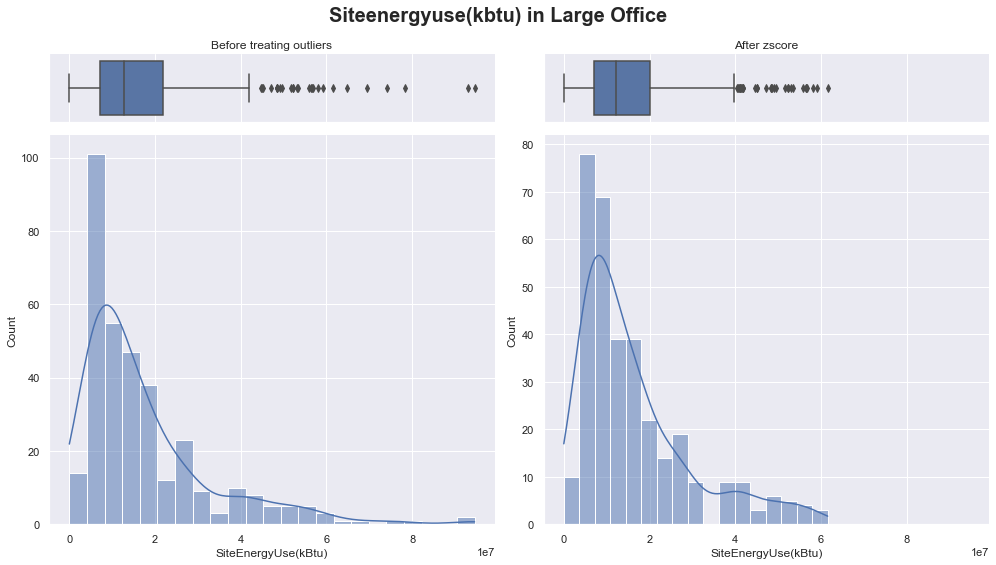

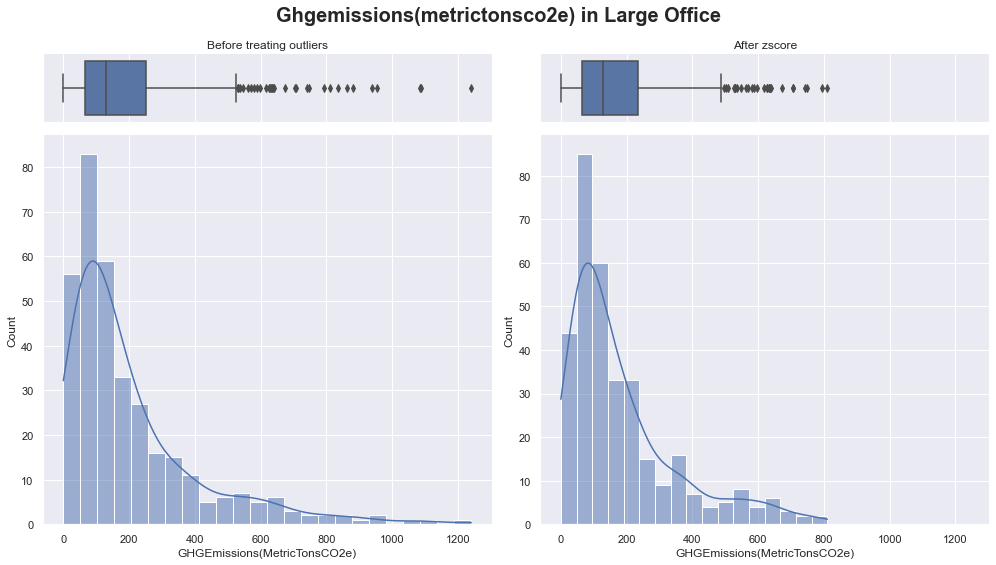

In [49]:
LIST_FEATURES_TO_PLOTT = ["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]
property_type = "Large Office"

df_temp = df_to_work[df_to_work["PrimaryPropertyType"] == property_type].copy()
df_temp_by_zscore = df_without_outliers[df_without_outliers["PrimaryPropertyType"] == property_type].copy()

for col in LIST_FEATURES_TO_PLOTT:

    # Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    fig, ((ax_box, ax_box_zscore), (ax_hist, ax_hist_zscore)) = \
                                                        plt.subplots(nrows=2, ncols=2, figsize=[14,8], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Title for the complete RR078466118RUfigure
    fig.suptitle((col.capitalize() + " in " + property_type), fontsize="x-large", fontweight="bold", size=20)

    # Assigning a graph to each ax
    ax_box.title.set_text("Before treating outliers")
    ax_box_zscore.title.set_text("After zscore")

    sns.boxplot(data=df_temp, x=col, ax=ax_box)
    sns.boxplot(data=df_temp_by_zscore, x=col, ax=ax_box_zscore)

    sns.histplot(data=df_temp, x=col, kde=True, ax=ax_hist)
    sns.histplot(data=df_temp_by_zscore, x=col, kde=True, ax=ax_hist_zscore)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")
    ax_box.set(yticks=[])
    ax_box_zscore.set(xlabel="")
    ax_box_zscore.set(yticks=[])

    plt.tight_layout()
    plt.savefig("img/outliers-" + (col[0:-5].capitalize()) + "-in-" + property_type + ".png")
    sns.despine(fig)

<div class="alert alert-block alert-success">
    Both percentiles and distributions appear similar
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Treating missing-values with KNN Imputer</h3>
</div>

<div class="alert alert-block alert-info">
    We are just going to treat missing-values with KNN Imputer 
</div>

<div style="background-color: #6D83C5;">
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.1. Testing imputation of KNN Imputer</h4>
</div>
<br>
<div style="background-color: #6D83C5;">
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.1 Selecting subset of data</h5>
</div>

In [50]:
df_analysis(df_without_outliers, "df_without_outliers", type_analysis="complete")


Analysis of df_without_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            2034
- Percentage of NaN:              2.82 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 696.1+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NumberofFloors,float64,3252,44,25,0.76000,4.15160,1.00000,1.00000,2.00000,4.00000,99.00000,6.60947
7,NumberofBuildings,float64,3223,16,54,1.65000,1.10270,1.00000,1.00000,1.00000,1.00000,39.00000,1.14105
18,SteamUse(kBtu),float64,3215,172,62,1.89000,328248.64310,0.00000,0.00000,0.00000,0.00000,134943456.00000,4819764.46280


<div class="alert alert-block alert-info">
    To select <b>the imputation way of missing-values</b>, we will go through the following steps:
    <ul style="list-style-type: square;">
        <li>Select a  <b>subset</b> of data</li>
        <li>Split subset into <b>Training</b> and <b>Testing Sets</b></li>
        <li>Make imputation through <b>KNN Imputer</b> </li>
        <li><b>Comparison</b> of imputation using <b>RMSE</b> </li>
    </ul>
</div>
<div class="alert alert-block alert-info">
    <b>Selecting</b> the features to work on them
</div>

In [51]:
LIST_OF_FEATURES_TREAT_NaN = [
    "PrimaryPropertyType", "renamed_PrimaryPropertyType", "YearBuilt", "PropertyGFATotal", 
    "NumberofFloors", "NumberofBuildings", "Neighborhood", "Electricity(kBtu)", "NaturalGas(kBtu)", 
    "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", 
    "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SteamUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", 
    "GHGEmissionsIntensity(kgCO2e/ft2)", "ENERGYSTARScore"
]

CATEGORICAL_FEATURES = ["PrimaryPropertyType", "renamed_PrimaryPropertyType", "Neighborhood"]

NUMERIC_FEATURES = [
    "YearBuilt", "PropertyGFATotal", "NumberofFloors", "NumberofBuildings", "Electricity(kBtu)", 
    "NaturalGas(kBtu)", "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", 
    "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SteamUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", 
    "GHGEmissionsIntensity(kgCO2e/ft2)", "ENERGYSTARScore"
]

<div class="alert alert-block alert-info">
    <b>Selecting</b> only the <b>rows without missing-values</b>
</div>

In [52]:
df_subset = pd.DataFrame(df_without_outliers[LIST_OF_FEATURES_TREAT_NaN])

In [53]:
df_subset = pd.DataFrame(df_subset[df_subset[list(set(df_subset._get_numeric_data()))].notnull().all(axis=1)])

In [54]:
df_subset.shape

(1951, 19)

<div class="alert alert-block alert-success">
    At this point, we have a <b>subset of data</b> with more or less the <b>54%</b> of data of <b>df_without_outliers</b> and the most important, <b>without missing-values</b>
</div>
<div class="alert alert-block alert-info">
    Making <b>OneHotEncoder</b>
</div>

In [55]:
ohe = OneHotEncoder(sparse=False)

In [56]:
array_ohe = ohe.fit_transform(df_subset[CATEGORICAL_FEATURES])

In [57]:
df_ohe = pd. DataFrame(array_ohe, index=df_subset.index)

In [58]:
df_subset_OneHotEncoder = df_subset.drop(columns=CATEGORICAL_FEATURES)

In [59]:
df_subset_OneHotEncoder = pd.concat([df_ohe, df_subset_OneHotEncoder], axis=1)

In [60]:
df_subset_OneHotEncoder.head()

,0,1,2,3,4,5,6,7,8,9,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ENERGYSTARScore
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,249.43,2.64,65.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,263.51,2.38,51.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,507.70,4.02,67.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,76.9,79.6,6252842.0,6477493.0,149.5,158.2,0.0,208.46,2.37,25.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,77.0,82.9,12633744.0,13589025.0,174.6,186.8,0.0,331.61,1.83,46.0


<div class="alert alert-block alert-info">
    <b>Normalizing</b> the datesets 
</div>

In [61]:
scaler = MinMaxScaler()

In [62]:
scaler_features = scaler.fit_transform(df_subset_OneHotEncoder)

In [63]:
df_subset_OneHotEncoder = pd.DataFrame(scaler_features, index=df_subset_OneHotEncoder.index, columns=df_subset_OneHotEncoder.columns)

In [64]:
df_subset_OneHotEncoder.head()

,0,1,2,3,4,5,6,7,8,9,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ENERGYSTARScore
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.195249,0.193168,0.023601,0.023838,0.190074,0.190471,0.014992,0.020267,0.156121,0.646465
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.233606,0.238153,0.028242,0.029441,0.209575,0.212335,0.000000,0.021411,0.140745,0.505051
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.297204,0.293721,0.050130,0.050642,0.250657,0.247036,0.000000,0.041252,0.237729,0.666667
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.190299,0.191484,0.021138,0.021755,0.163782,0.172087,0.000000,0.016938,0.140154,0.242424
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.190547,0.199423,0.042709,0.045640,0.191280,0.203198,0.000000,0.026944,0.108220,0.454545


<div class="alert alert-block alert-info">
    <b>Slipt</b> the dataset into <b>train</b> and <b>test</b>. We are goint to work with the configuration below
    <ul style="list-style-type: square;">
        <li><b>Spliting</b> the dataset without missing-values into <b>70% training dataset</b> and <b>30% testing dataset</b></li>
        <li><b>To assign NaN 99%</b> of data for <b>SourceEUIWN(kBtu/sf)</b> column in the <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>Concatenating</b> the <b>training dataset</b> with <b>testing dataset (with 100% of NaN in testing dataset)</b> to make the <b>transform()</b></li>
    </ul>
</div>

In [65]:
X_train, X_test = train_test_split(df_subset_OneHotEncoder, test_size=0.3, random_state=0)

In [66]:
X_test["SourceEUIWN(kBtu/sf)"] = np.NaN
# X_test["SourceEUIWN(kBtu/sf)"] = X_test["SourceEUIWN(kBtu/sf)"].mask(np.random.random(X_test.shape[0]) < 0.99)

<ipython-input-66-091fac65d776>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["SourceEUIWN(kBtu/sf)"] = np.NaN


In [67]:
X_test = pd.concat([X_train, X_test])

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.2. Making imputation with KNN Imputer</h5>
</div>

In [68]:
impute = KNNImputer()

In [69]:
impute.fit(X_train)

KNNImputer()

In [70]:
temp_imputed = impute.transform(X_test)

In [71]:
df_X_test = pd.DataFrame(temp_imputed, index=X_test.index, columns=X_test.columns)

<div class="alert alert-block alert-info">
    <b>DESNormalizing</b> the datesets 
</div>

In [72]:
df_X_test = pd.DataFrame(scaler.inverse_transform(df_X_test), index=df_X_test.index, columns=df_X_test.columns)

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.3. Comparison of imputations on subsets</h5>
</div>

In [73]:
df_X_test.drop(columns=[col for col in df_X_test.columns if col not in LIST_OF_FEATURES_TREAT_NaN], inplace=True)

In [74]:
df_X_test = df_X_test.join(df_subset[CATEGORICAL_FEATURES])

<div class="alert alert-block alert-info">
    <b>Identifying</b> the groups of <b>PrimaryPropertyType</b> with more data
</div>

In [75]:
df_X_test.groupby(["PrimaryPropertyType", "renamed_PrimaryPropertyType", "Neighborhood"])["PrimaryPropertyType"].count().sort_values(ascending=False).head(3)

PrimaryPropertyType         renamed_PrimaryPropertyType  Neighborhood    
Large Office                Office                       DOWNTOWN            165
Small and Mid-Sized Office  Office                       DOWNTOWN            125
Warehouse                   Warehouse                    GREATER DUWAMISH     90
Name: PrimaryPropertyType, dtype: int64

In [76]:
df_subset["data"] = "Original"
df_X_test["data"] = "KNN Imputer"
df_comparision = pd.concat([df_subset, df_X_test])
df_comparision = df_comparision[df_comparision["PrimaryPropertyType"] == "Small and Mid-Sized Office"].copy()

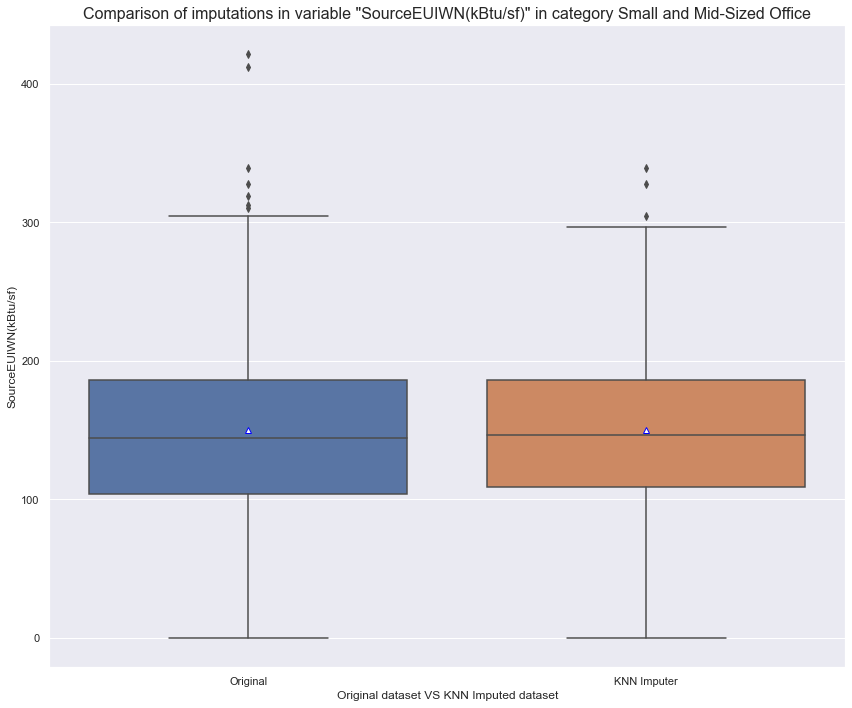

In [77]:
plt.figure(figsize=[12,10])
sns.boxplot(x=df_comparision["data"], y=df_comparision["SourceEUIWN(kBtu/sf)"], showmeans=True, 
            meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
plt.title("Comparison of imputations in variable \"SourceEUIWN(kBtu/sf)\" in category Small and Mid-Sized Office", size=16)
plt.xlabel("Original dataset VS KNN Imputed dataset", size=12)
plt.tight_layout()
plt.savefig("img/Comparison-of-imputations.png")
plt.show()

<div class="alert alert-block alert-success">
    At this point, we get that <b>percentiles</b> appear <b>very similar</b> between original data and KNN imputed data
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.4. Calculating Root Mean Square Error - RMSE</h5>
</div>

<div class="alert alert-block alert-info">
    Calculating <b>Root Mean Square Error</b>
</div>

In [78]:
MSE = mean_squared_error(
    df_comparision.loc[df_comparision["data"] == "Original", "SourceEUIWN(kBtu/sf)"],
    df_comparision.loc[df_comparision["data"] == "KNN Imputer", "SourceEUIWN(kBtu/sf)"]
)
RMSE = round(math.sqrt(MSE), 2)
print("Root Mean Square Error by KNN Imputer is :", RMSE)

Root Mean Square Error by KNN Imputer is : 88.82


<div class="alert alert-block alert-success">
    <b>Root Mean Square Error</b> by KNN Imputer is a <b>little high but, acceptable</b> considering the quantity of data
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2. Making imputation with KNN Imputer</h4>
</div>

<div class="alert alert-block alert-info">
    Selecting the features to make the imputation
</div>

In [79]:
df_data = pd.DataFrame(df_without_outliers[LIST_OF_FEATURES_TREAT_NaN])

<div class="alert alert-block alert-info">
    Making <b>OneHotEncoder</b> to <b>dataset</b>
</div>

In [80]:
array_ohe = ohe.fit_transform(df_data[CATEGORICAL_FEATURES])

In [81]:
df_data_ohe = pd.DataFrame(array_ohe, index=df_data.index)

In [82]:
df_data_OneHotEncoder = df_data.drop(columns=CATEGORICAL_FEATURES)

In [83]:
df_data_OneHotEncoder = pd.concat([df_data_ohe, df_data_OneHotEncoder], axis=1)

In [84]:
df_data_OneHotEncoder.head()

,0,1,2,3,4,5,6,7,8,9,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ENERGYSTARScore
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,249.43,2.64,65.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,263.51,2.38,51.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.6,99.7,NaN,NaN,242.7,246.5,NaN,2061.48,1.92,18.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,28229320.0,28363444.0,NaN,NaN,NaN,1936.34,NaN,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,507.70,4.02,67.0


<div class="alert alert-block alert-info">
    <b>Normalizing</b> the <b>training final dataset</b>
</div>

In [85]:
scaler_features = scaler.fit_transform(df_data_OneHotEncoder)

In [86]:
df_data_OneHotEncoder_normalized = pd.DataFrame(scaler_features, index=df_data_OneHotEncoder.index, columns=df_data_OneHotEncoder.columns)

In [87]:
df_data_OneHotEncoder_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ENERGYSTARScore
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.113248,0.115856,0.023601,0.023838,0.143781,0.146515,0.014992,0.020267,0.102684,0.646465
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.135496,0.142837,0.028242,0.029441,0.158532,0.163334,0.000000,0.021411,0.092571,0.505051
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.138654,0.143846,NaN,NaN,0.201127,0.206259,NaN,0.167502,0.074679,0.171717
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.095430,0.095262,NaN,NaN,NaN,0.157334,NaN,0.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.172384,0.176165,0.050130,0.050642,0.189608,0.190026,0.000000,0.041252,0.156359,0.666667


<div class="alert alert-block alert-info">
    Making a <b>mask</b> to filter the records <b>without missing-values</b> to use them <b>to fit</b> the <b>KNN Imputer</b>
</div>

In [88]:
mask = df_data_OneHotEncoder_normalized[list(set(df_data_OneHotEncoder_normalized._get_numeric_data()))].notnull().all(axis=1)

In [89]:
df_training_data = df_data_OneHotEncoder_normalized[mask].copy()

In [90]:
df_training_data.shape

(1951, 61)

<div class="alert alert-block alert-success">
    At this point we got <b>almost 60%</b> of data with <b>without missing-values</b> to use them to fit the <b>KNN Imputer</b>
</div>

<div class="alert alert-block alert-info">
    <b>Making</b> imputation with <b>KNN Imputer</b> in <b>final dataset</b>
</div>

In [91]:
impute = KNNImputer()

In [92]:
impute.fit(df_training_data)

KNNImputer()

In [93]:
temp_imputed = impute.transform(df_data_OneHotEncoder_normalized)

In [94]:
df_data_OneHotEncoder_normalized = pd.DataFrame(temp_imputed, index=df_data_OneHotEncoder_normalized.index, columns=df_data_OneHotEncoder_normalized.columns)

<div class="alert alert-block alert-info">
    <b>DESNormalizing</b> the dateset
</div>

In [95]:
df_data_OneHotEncoder = pd.DataFrame(scaler.inverse_transform(df_data_OneHotEncoder_normalized), index=df_data_OneHotEncoder_normalized.index, columns=df_data_OneHotEncoder_normalized.columns)

<div class="alert alert-block alert-info">
    <b>Formatting</b> the dateset as original
</div>

In [96]:
df_data_OneHotEncoder.drop(columns=[col for col in df_data_OneHotEncoder.columns if col not in LIST_OF_FEATURES_TREAT_NaN], inplace=True)

In [97]:
data_cleaned = df_data_OneHotEncoder.join(df_without_outliers[CATEGORICAL_FEATURES])

In [98]:
data_cleaned = data_cleaned.join(df_without_outliers[["OSEBuildingID", "DataYear", "ZipCode"]])

In [99]:
data_cleaned = data_cleaned[LIST_FEATURES]

In [100]:
df_analysis(data_cleaned, "data_cleaned", type_canalysis="complete")


Analysis of data_cleaned dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 22 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 696.1+ KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3277,0,0.00000
1,DataYear,int64,3277,0,0.00000
20,GHGEmissionsIntensity(kgCO2e/ft2),float64,3277,0,0.00000
19,GHGEmissions(MetricTonsCO2e),float64,3277,0,0.00000
18,SteamUse(kBtu),float64,3277,0,0.00000
17,SourceEUIWN(kBtu/sf),float64,3277,0,0.00000
16,SourceEUI(kBtu/sf),float64,3277,0,0.00000
15,SiteEnergyUseWN(kBtu),float64,3277,0,0.00000
14,SiteEnergyUse(kBtu),float64,3277,0,0.00000
13,SiteEUIWN(kBtu/sf),float64,3277,0,0.00000


In [101]:
data_cleaned.to_csv("datasets\data_cleaned.csv", index=False)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6. Exploratory Data Analysis</h3>
</div>

In [102]:
data_cleaned

,OSEBuildingID,DataYear,PrimaryPropertyType,renamed_PrimaryPropertyType,YearBuilt,PropertyGFATotal,NumberofFloors,NumberofBuildings,ZipCode,Neighborhood,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),ENERGYSTARScore
0,1,2015,Hotel,Hotel,1927.0,88434.0,12.0,1.0,18081,DOWNTOWN,...,78.900000,80.300000,6.981428e+06,7.097539e+06,173.500000,175.100000,2023032.00,249.43,2.640,65.0
1,2,2015,Hotel,Hotel,1996.0,103566.0,11.0,1.0,18081,DOWNTOWN,...,94.400000,99.000000,8.354235e+06,8.765788e+06,191.300000,195.200000,0.00,263.51,2.380,51.0
2,3,2015,Hotel,Hotel,1969.0,330193.6,41.0,1.0,18081,DOWNTOWN,...,96.600000,99.700000,2.918879e+07,2.935459e+07,242.700000,246.500000,4502075.30,2061.48,1.920,18.0
3,5,2015,Hotel,Hotel,1926.0,61320.0,10.0,1.0,18081,DOWNTOWN,...,95.300000,99.860000,2.822932e+07,2.836344e+07,192.540002,198.520001,2213624.85,1936.34,3.546,1.0
4,8,2015,Hotel,Hotel,1980.0,119890.0,18.0,1.0,19576,DOWNTOWN,...,120.100000,122.100000,1.482910e+07,1.507824e+07,228.800000,227.100000,0.00,507.70,4.020,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,49699,2016,Warehouse,Warehouse,1988.0,45700.0,2.0,1.0,98178,SOUTHEAST,...,5.300000,5.300000,1.544194e+06,1.547490e+06,15.800000,15.800000,0.00,15.50,0.340,99.0
3255,50068,2016,Warehouse,Warehouse,1955.0,52085.0,1.0,1.0,98108,GREATER DUWAMISH,...,69.199997,80.300003,3.605856e+06,4.182622e+06,102.099998,114.599998,0.00,157.70,3.030,37.0
3267,50210,2016,Office,Office,1952.0,13661.0,1.0,1.0,0,MAGNOLIA / QUEEN ANNE,...,36.799999,40.900002,5.026677e+05,5.585251e+05,115.500000,128.399994,0.00,3.50,0.260,75.0
3270,50220,2016,Office,Office,1960.0,15398.0,1.0,1.0,0,SOUTHEAST,...,25.200001,26.900000,3.878100e+05,4.141724e+05,64.099998,66.699997,0.00,7.79,0.510,93.0


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1. Initial analysis</h4>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">6.1.1 Primary Property type distribution</h5>
</div>

In [103]:
data_piechart = data_cleaned["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().values
labels_piechart = data_cleaned["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#EAEAF2", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)

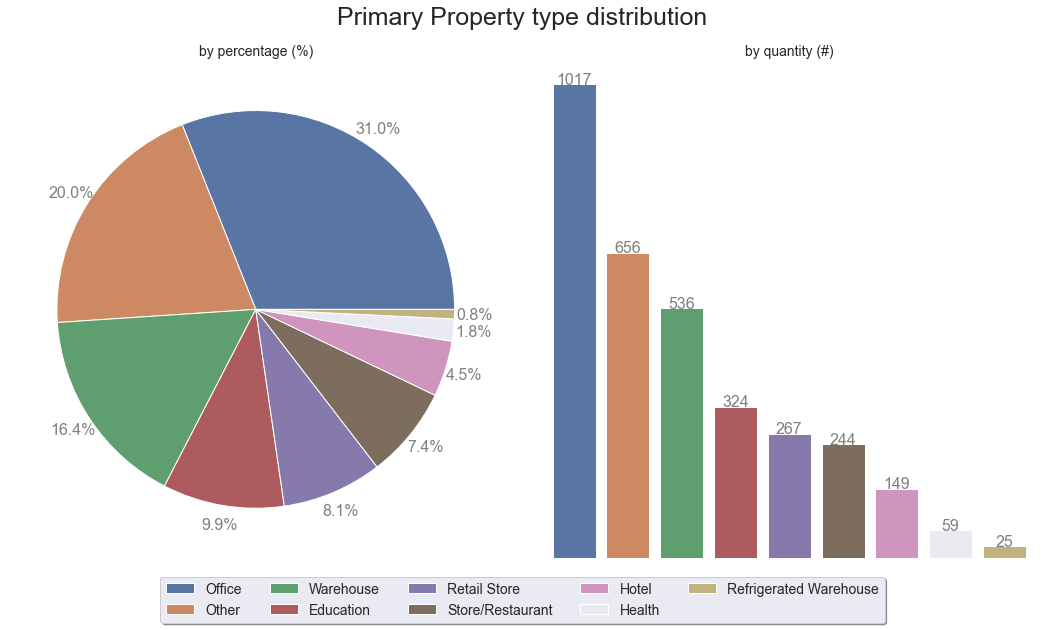

In [104]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,8])

fig.suptitle("Primary Property type distribution", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/primary-property-type-distribution.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">6.1.2  Comparison of the variables in each Property type</h5>
</div>

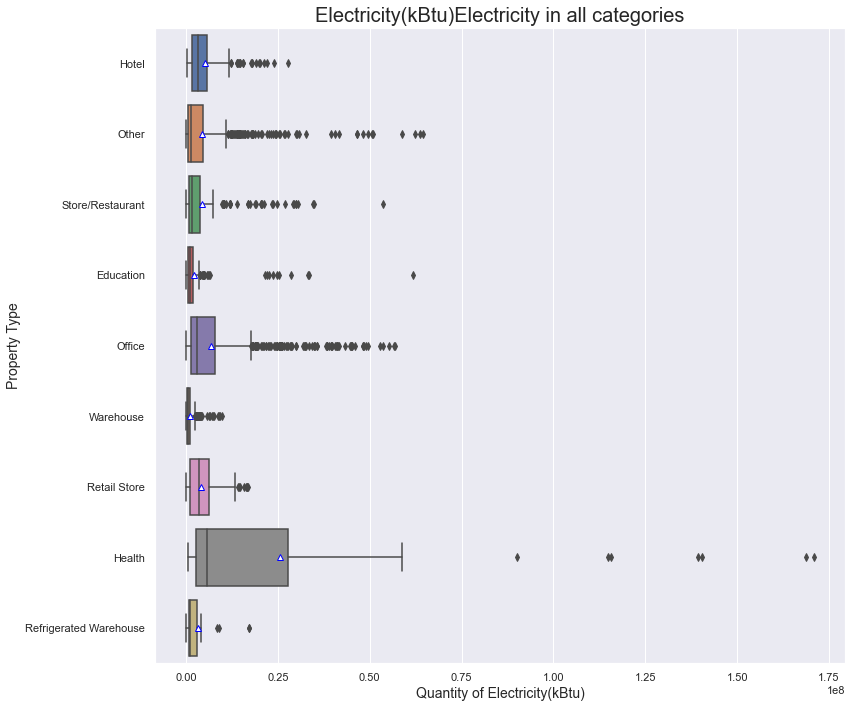

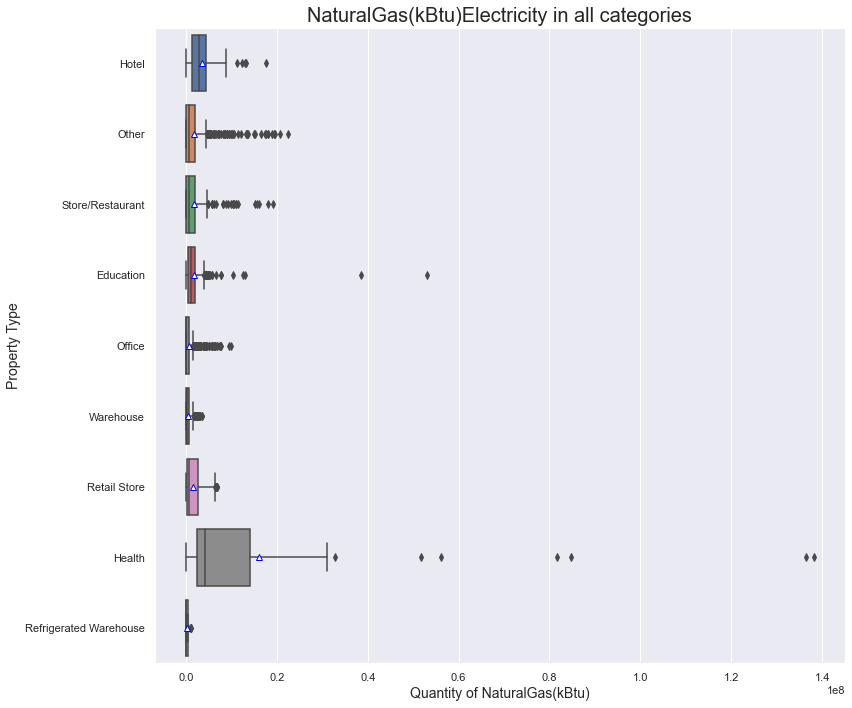

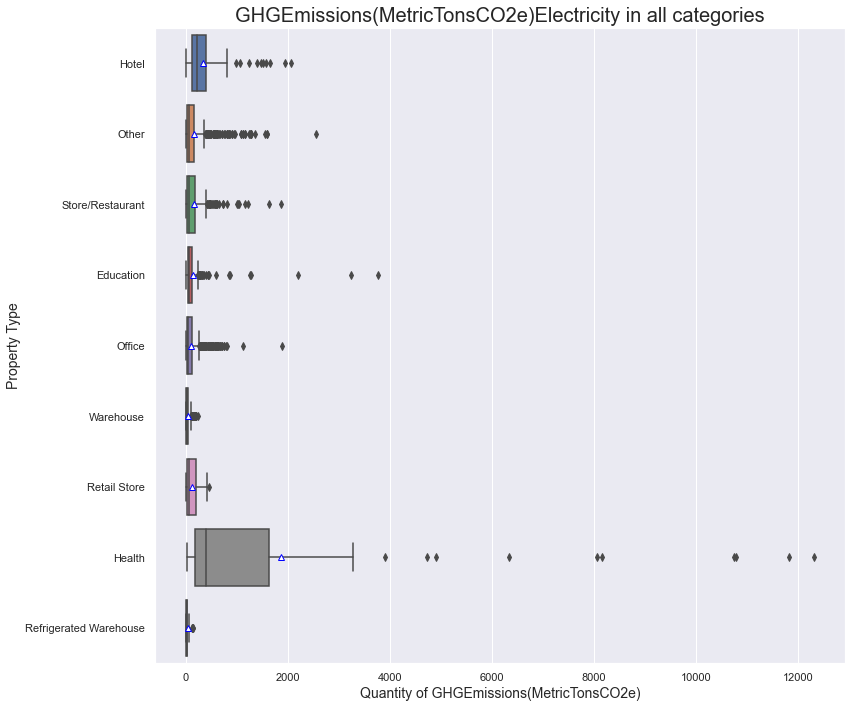

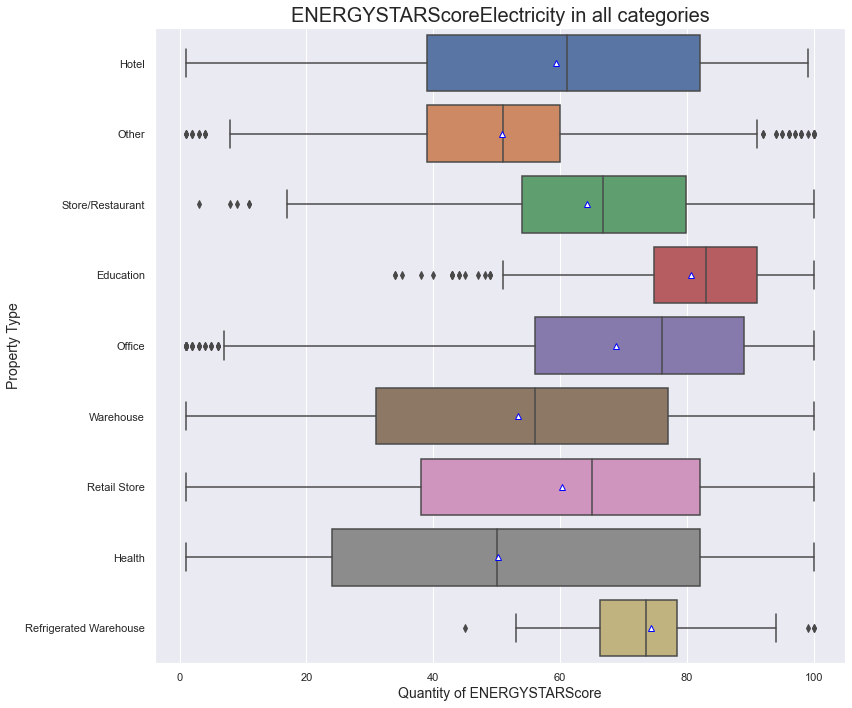

In [105]:
for var in ["Electricity(kBtu)", "NaturalGas(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"]:
    plt.figure(figsize=[12,10])
    sns.boxplot(x=data_cleaned[var], y=data_cleaned["renamed_PrimaryPropertyType"], orient="h", showmeans=True, 
                meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    plt.title(var + "Electricity in all categories", size=20)
    plt.ylabel("Property Type", size=14)
    plt.xlabel("Quantity of " + var, size=14)
    plt.tight_layout()
    plt.savefig("img/comparison-of-" + var + "-in-each-category.png")
    plt.show()

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">6.1.2  Comparison by Years</h5>
</div>

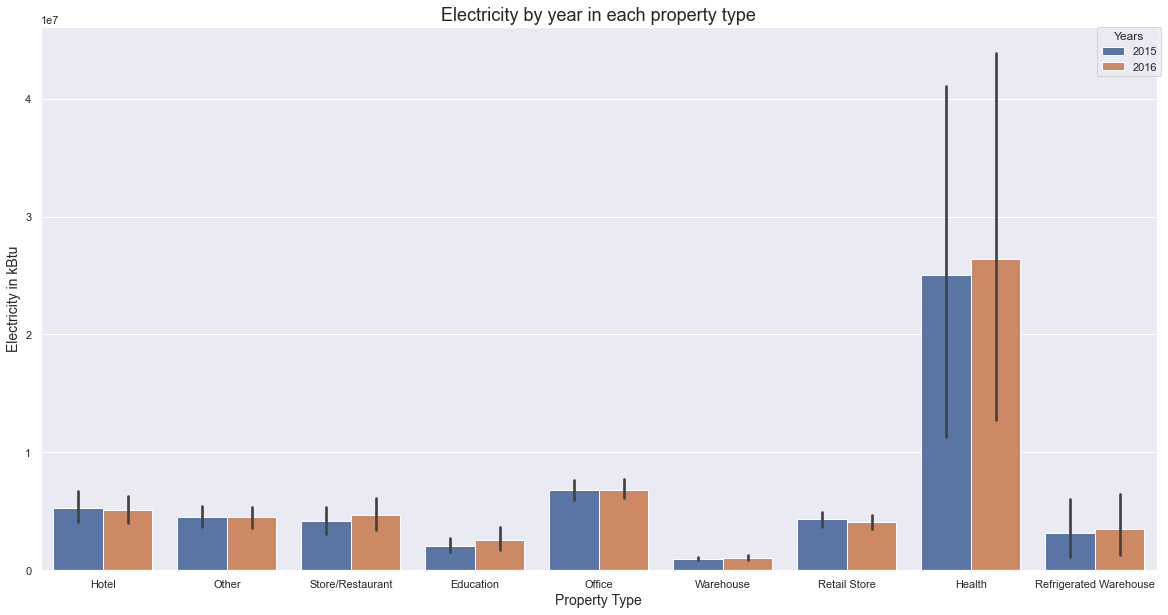

In [106]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="Electricity(kBtu)", 
            hue="DataYear", 
            data=data_cleaned)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Electricity in kBtu", size=14)
plt.xlabel("Property Type", size=14)
plt.title("Electricity by year in each property type", size=18)
plt.savefig("grouped-electricity-by-year.png")

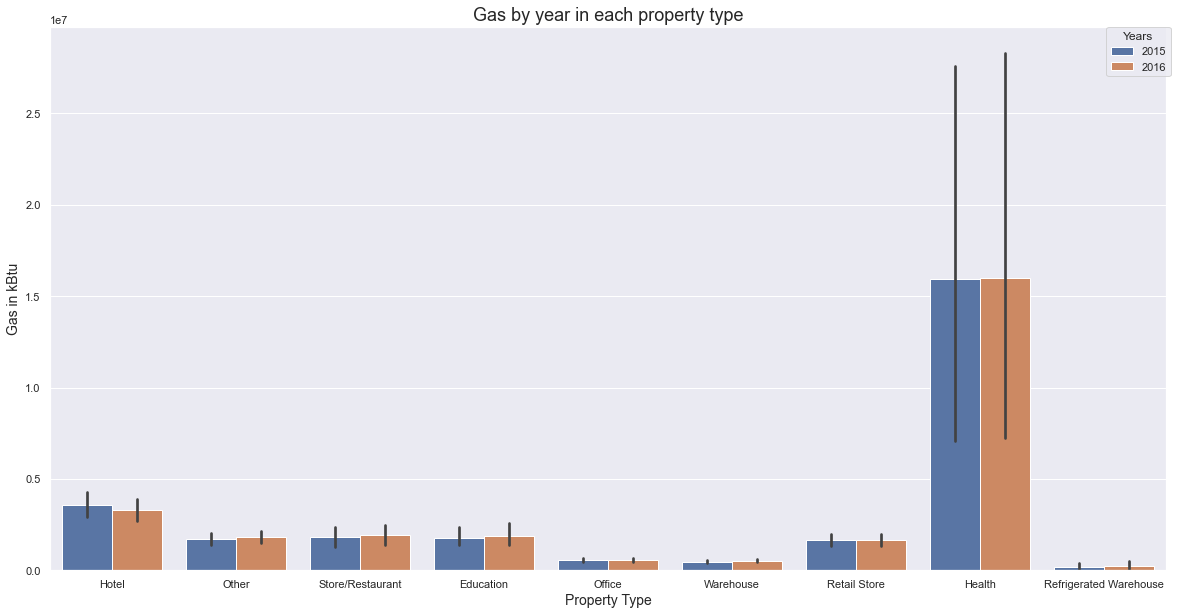

In [107]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="NaturalGas(kBtu)", 
            hue="DataYear", 
            data=data_cleaned)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Gas in kBtu", size=14)
plt.xlabel("Property Type", size=14)
plt.title("Gas by year in each property type", size=18)
plt.savefig("grouped-naturalgas-by-year.png")

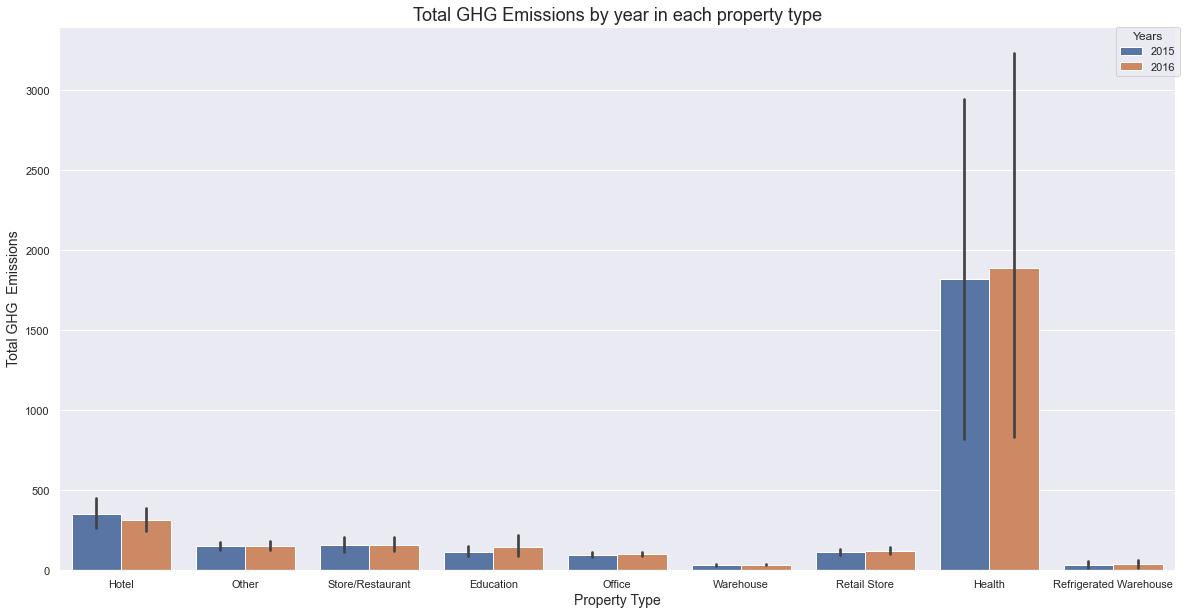

In [108]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="GHGEmissions(MetricTonsCO2e)", 
            hue="DataYear", 
            data=data_cleaned)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Total GHG  Emissions", size=14)
plt.xlabel("Property Type", size=14)
plt.title("Total GHG Emissions by year in each property type", size=18)
plt.savefig("grouped-TotalGHGEmissions-by-year.png")

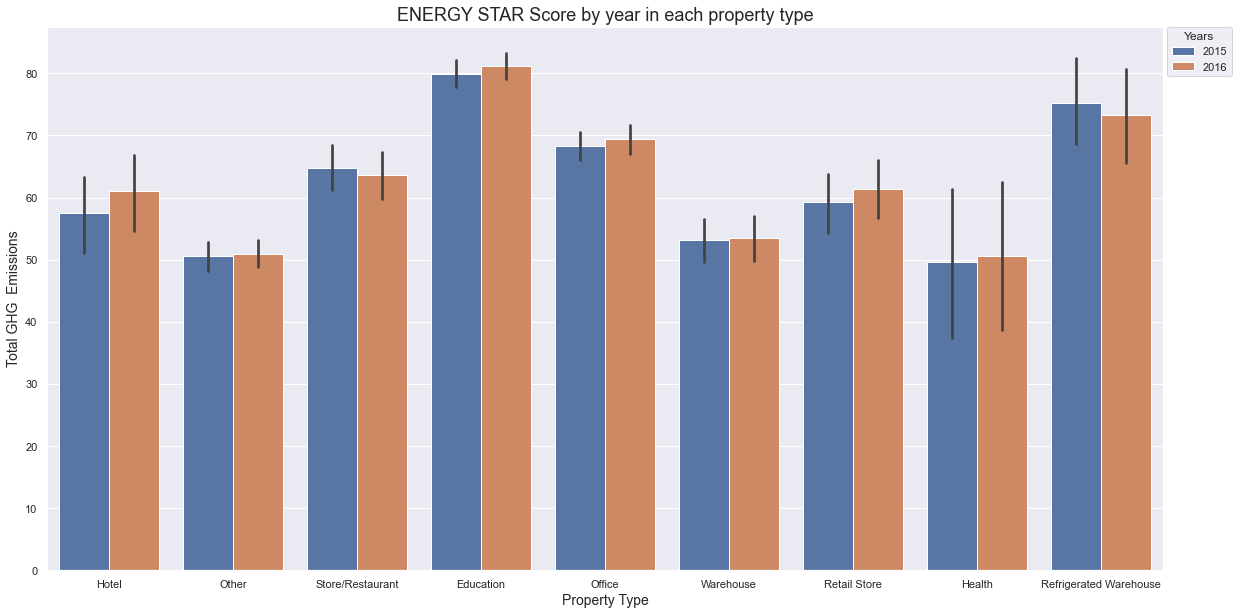

In [109]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="ENERGYSTARScore", 
            hue="DataYear", 
            data=data_cleaned)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Total GHG  Emissions", size=14)
plt.xlabel("Property Type", size=14)
plt.title("ENERGY STAR Score by year in each property type", size=18)
plt.savefig("grouped-ENERGYSTARScore-by-year.png")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2. Univariate analysis</h4>
</div>

In [110]:
data_cleaned["renamed_PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Store/Restaurant', 'Education', 'Office',
       'Warehouse', 'Retail Store', 'Health', 'Refrigerated Warehouse'],
      dtype=object)

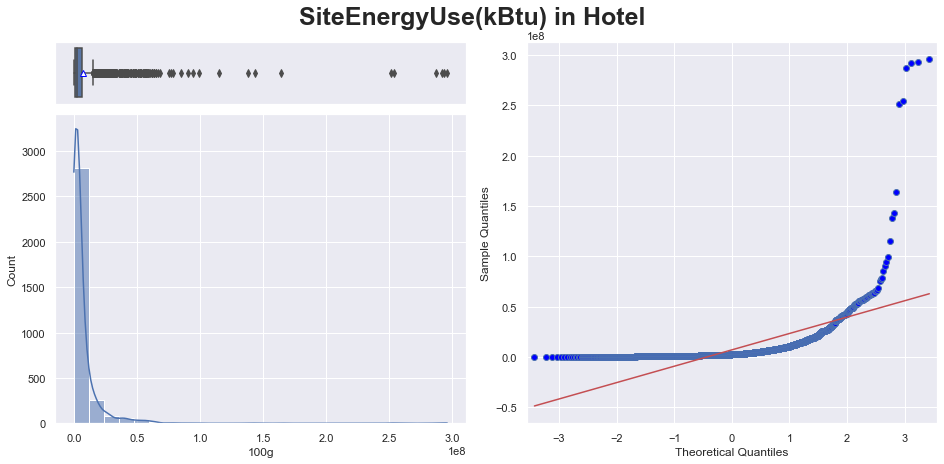

In [ ]:
for property_type in data_cleaned["renamed_PrimaryPropertyType"].unique():
    
#     df_temp = data_cleaned[data_cleaned["renamed_PrimaryPropertyType"] == property_type].copy()
    df_temp = data_cleaned.copy()
    
#     for var in ["Electricity(kBtu)", "NaturalGas(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"]:
    for var in ["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"]:


        fig = plt.figure(constrained_layout=True, figsize=[13,6])
        fig.suptitle(var + " in " + property_type, size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])

        # Boxplot
        boxplot = sns.boxplot(data=df_temp, 
                              x=df_temp[var], 
                              showmeans=True, ax=ax_box,
                              meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")

        # Histplot
        sns.histplot(data=df_temp, 
                     x=df_temp[var], 
                     bins=25,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel="100g")

        # QQplot
        qqplot(df_temp[var], line='s', ax=ax_qqplot)

        plt.savefig("img/qqplot-of-" + var + "-in-" + property_type.replace("/", "-") + ".png")
        plt.show()
    
    print("\nMaking the Normality Test")
    print("Property type: (", property_type, ")")
    print("---------------------------------------------------------------------------------------------")
    normality_test(df_temp[["Electricity(kBtu)", "NaturalGas(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"]])
    print("\n\n\n")

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3. Bivariate analysis</h4>
</div>

In [ ]:
data_cleaned["renamed_PrimaryPropertyType"].unique()

In [ ]:
df_subset = data_cleaned[data_cleaned["renamed_PrimaryPropertyType"].isin(["Hotel"])]

In [ ]:
VARIABLES = ["Electricity(kBtu)", "NaturalGas(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"]

In [ ]:
list_variables, list_COEF, list_MSE, list_RMSE, list_R2SCORE = ([] for i in range(5))

for a, b in itertools.combinations(VARIABLES, 2):
    
    # initializing Linear Regression by Pearson
    lr = LinearRegression()
    xtrain, xtest, ytrain, ytest = train_test_split(df_subset[[a]], df_subset[[b]], test_size=0.3)
    lr = LinearRegression()
    lr_baseline = lr.fit(xtrain, ytrain)
    pred_baseline = lr_baseline.predict(xtest)
    
    list_variables.append(a + " vs " + b)
    list_COEF.append(round(lr_baseline.coef_[0,0], 4))
    list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
    list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
    list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))
    
    # PLotting the graph
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    
    plt.suptitle(a + " vs " + b, fontsize=20, y=0.96)
    plt.title("Hotel",fontsize=16)
    plt.plot(xtest, ytest, 'bo', markersize = 5)
    plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
    plt.xlabel(a, size=14)
    plt.ylabel(b, size=14)
    plt.tight_layout()
    plt.savefig("img/correlation-" + a + "-vs-" + b + ".png")
    plt.show()
    
df_metrics_bivariate = pd.DataFrame({
    "variables":list_variables,
    "Coef.":list_COEF,
    "MSE":list_MSE,
    "RMSE":list_RMSE,
    "R2SCORE":list_R2SCORE
})
df_metrics_bivariate